In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 255
CHANNEL = 3
EPOCKS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "C://Users//aloky//OneDrive//Desktop//quick-y//Backend//Dataset",
    seed = 123,
    shuffle = True,
    image_size = [IMAGE_SIZE, IMAGE_SIZE],
    batch_size = BATCH_SIZE,                                            
)

Found 886 files belonging to 6 classes.


In [5]:
len(dataset)

56

In [6]:
class_names = dataset.class_names
class_names

['Akne', 'Benign', 'Ekzama', 'Enfeksiyonel', 'Malign', 'Pigment']

In [7]:
import numpy as np
for batch_size, label_size in dataset.take(1):
    print("image shape", np.array(batch_size.shape))
    print("label:", np.array(label_size))
    print("Image:" , batch_size[0])

image shape [ 16 255 255   3]
label: [4 4 4 1 4 3 2 3 4 1 4 1 5 0 5 4]
Image: tf.Tensor(
[[[157.75786  101.75786   86.75786 ]
  [157.00401  101.00401   84.00401 ]
  [159.05083  103.80875   84.53499 ]
  ...
  [179.55878  132.55878  122.55878 ]
  [176.26953  128.26953  116.26954 ]
  [174.25388  126.25388  114.25388 ]]

 [[159.77348  103.77348   88.77348 ]
  [160.5353   107.53529   91.03557 ]
  [160.72624  107.72624   89.72624 ]
  ...
  [183.85605  135.85605  125.85604 ]
  [179.00002  129.00002  120.000015]
  [174.51172  124.51172  113.51172 ]]

 [[161.80498  108.80498   94.80498 ]
  [163.80467  110.80467   94.80467 ]
  [162.75038  109.75039   92.24962 ]
  ...
  [185.05801  135.05801  128.05801 ]
  [180.56317  130.56317  121.56318 ]
  [174.00781  121.00781  113.00781 ]]

 ...

 [[171.07431  132.07431  127.07431 ]
  [168.4534   127.4534   123.4534  ]
  [167.90575  123.905754 120.905754]
  ...
  [157.86948  100.86948   80.86948 ]
  [157.70276  100.70276   81.70276 ]
  [159.75792  102.75792 

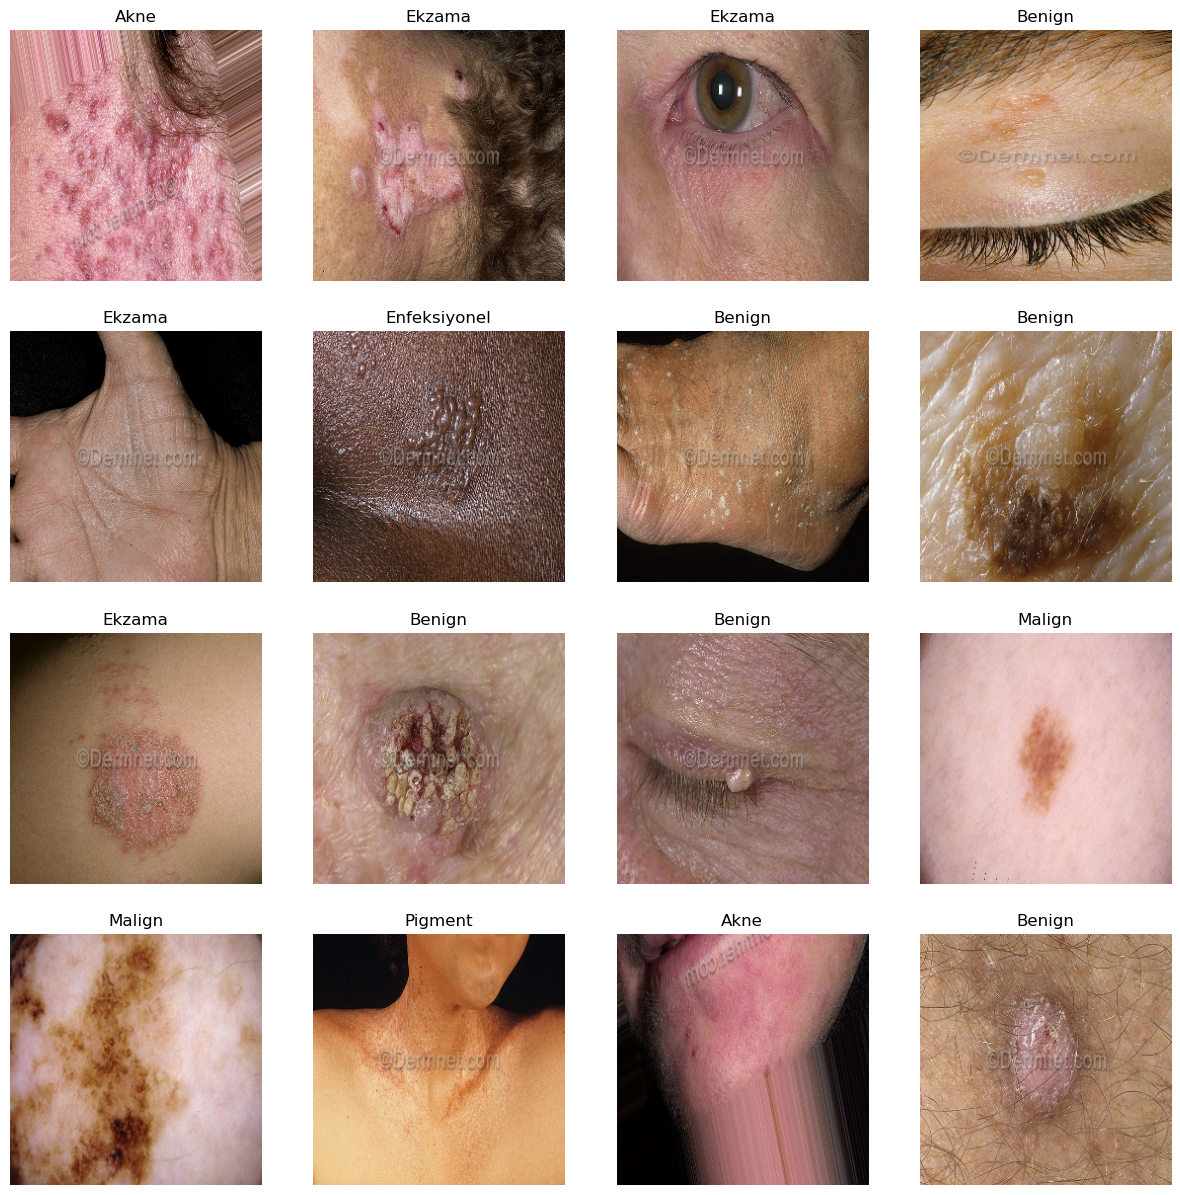

In [8]:
plt.figure(figsize=(15,15))
for img, label in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.80, val_split=.10, test_split=0.1, shuffel=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) == 1
    
    ds_size = len(ds)
    if shuffel:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(44, 5, 7)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255.0)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.20)
])

In [14]:
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True),y)).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_class = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])

model.build(input_shape=input_shape)

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [18]:
history = model.fit(train_ds, batch_size= BATCH_SIZE, validation_data=val_ds, verbose=1, epochs=30)

Epoch 1/30
44/44 [==============================] - 74s 1s/step - loss: 1.8603 - accuracy: 0.2344 - val_loss: 1.8600 - val_accuracy: 0.1250
Epoch 2/30
44/44 [==============================] - 61s 1s/step - loss: 1.6501 - accuracy: 0.3253 - val_loss: 1.7980 - val_accuracy: 0.1750
Epoch 3/30
44/44 [==============================] - 60s 1s/step - loss: 1.5832 - accuracy: 0.3622 - val_loss: 1.7666 - val_accuracy: 0.3000
Epoch 4/30
44/44 [==============================] - 62s 1s/step - loss: 1.5427 - accuracy: 0.3778 - val_loss: 1.8198 - val_accuracy: 0.1875
Epoch 5/30
44/44 [==============================] - 65s 1s/step - loss: 1.4899 - accuracy: 0.4162 - val_loss: 1.6576 - val_accuracy: 0.3375
Epoch 6/30
44/44 [==============================] - 66s 2s/step - loss: 1.4425 - accuracy: 0.4062 - val_loss: 1.6823 - val_accuracy: 0.2500
Epoch 7/30
44/44 [==============================] - 63s 1s/step - loss: 1.4154 - accuracy: 0.4560 - val_loss: 1.6351 - val_accuracy: 0.3125
Epoch 8/30
44/44 [==

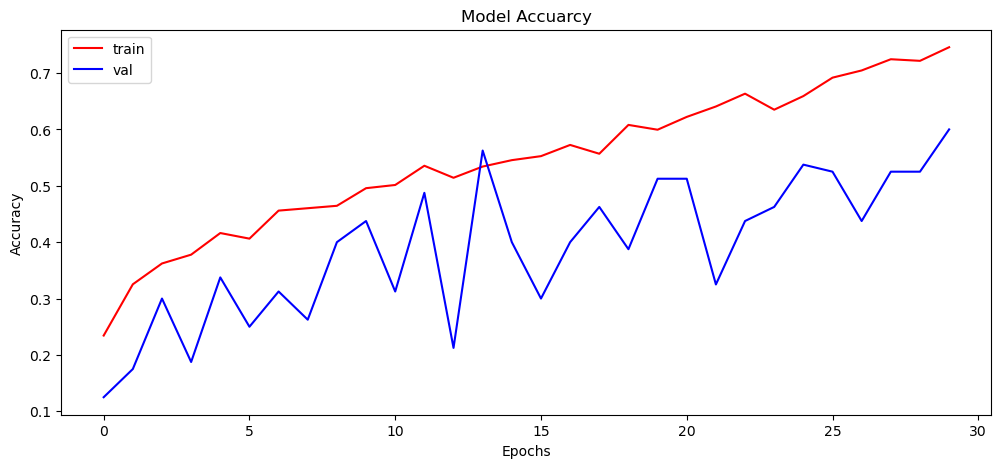

In [19]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title("Model Accuarcy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['train', 'val'])

In [20]:
model.evaluate(test_ds)

7/7 [==============================] - 7s 278ms/step - loss: 1.3935 - accuracy: 0.4911


[1.3935269117355347, 0.4910714328289032]

In [21]:
model.save("new_model.h5")

C:\Users\aloky\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
